<a href="https://colab.research.google.com/github/tateriordan/EPL-Match-Predictor/blob/main/DNN_and_LogisticRegression1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import pandas as pd
import statistics
import numpy as np
with open('/content/drive/Shared drives/Cs539 Project/EPLDataset.csv', 'r') as f:
  A1 = np.genfromtxt(f, delimiter=',')
with open('/content/drive/Shared drives/Cs539 Project/EPL2020.csv', 'r') as f:
  A = np.genfromtxt(f, delimiter=',')

df = pd.read_csv('/content/drive/Shared drives/Cs539 Project/EPLDataset.csv', header=[0])
df1 = pd.read_csv('/content/drive/Shared drives/Cs539 Project/EPL2020.csv', header=[0])
df.head()

Mounted at /content/drive


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,13/08/2021,20:00,Brentford,Arsenal,2,0,H,1,0,...,1.62,0.50,1.75,2.05,1.81,2.13,2.05,2.17,1.80,2.09
1,E0,14/08/2021,12:30,Man United,Leeds,5,1,H,1,0,...,2.25,-1.00,2.05,1.75,2.17,1.77,2.19,1.93,2.10,1.79
2,E0,14/08/2021,15:00,Burnley,Brighton,1,2,A,1,0,...,1.62,0.25,1.79,2.15,1.81,2.14,1.82,2.19,1.79,2.12
3,E0,14/08/2021,15:00,Chelsea,Crystal Palace,3,0,H,2,0,...,1.94,-1.50,2.05,1.75,2.12,1.81,2.16,1.93,2.06,1.82
4,E0,14/08/2021,15:00,Everton,Southampton,3,1,H,0,1,...,1.67,-0.50,2.05,1.88,2.05,1.88,2.08,1.90,2.03,1.86


In [2]:

colsToKeep = list(["Div","Date","HomeTeam","AwayTeam","FTHG","HG","FTAG","AG","FTR","Res","HTHG","HTAG","HTR","HS","AS","HST","AST","HHW","AHW","HC","AC","HF","AF","HO","AO","HY","AY","HR","AR"])
allCols = df.columns
colsToDrop = set(allCols) - set(colsToKeep)
df = df.drop(labels=colsToDrop,axis=1)
df1 = df1.drop(labels=colsToDrop,axis=1)

In [3]:
raw_season_data = {}
raw_season_data[0] = df
raw_season_data[1] = df1

In [5]:
def create_home_dict(table,matchNum):
    matchDict={}
    if any('FTR' == table.keys()):
        matchDict={'result':table['FTR'].values[0]}
    elif any('Res'== table.keys()):
        matchDict = {'result':table['Res'].values[0]}
    if any('FTHG' == table.keys()):
        matchDict.update({'Goals':table['FTHG'].values[0]})
    elif any('HG'== table.keys()):
        matchDict.update({'Goals':table['HG'].values[0]})
    if any('FTAG' == table.keys()):
        matchDict.update({'GoalsConceded':table['FTAG'].values[0]})
    elif any('AG'== table.keys()):
        matchDict.update({'GoalsConceded':table['AG'].values[0]})
    matchDict.update({'match':matchNum,'ground':'H', \
                        'Date':table['Date'].values[0],\
                        'TeamAgainst':table['AwayTeam'].values[0],\
                        'HTGoals':table['HTHG'].values[0], \
                        'HTResult':table['HTR'].values[0], \
                        #'Attendance':table['Attendance'].values[0], \
                        'Shots':table['HS'].values[0],\
                        'ShotsAgainst':table['AS'].values[0],\
                        'ShotsOnTarget':table['HST'].values[0],\
                        'ShotsAgainstOnTarget':table['AST'].values[0],\
                        #'ShotsWoodwork':table['HHW'].values[0],\
                        #'ShotsAgainstWoodwork':table['AHW'].values[0],\
                        'Corners':table['HC'].values[0],\
                        'CornersAgainst':table['AC'].values[0],\
                        'FoulsCommited':table['HF'].values[0],\
                        'FoulsAgainst':table['AF'].values[0],\
                        #'Offsies':table['HO'].values[0],\
                        #'OffsidesAgainst':table['AO'].values[0],\
                        'YCards':table['HY'].values[0],\
                        'YCardsAgainst':table['AY'].values[0],\
                        'RCards':table['HR'].values[0],\
                        'RCardsAgainst':table['AR'].values[0]})
                        #'BookingPoints':table['HBP'].values[0],\
                        #'BookingPointsAgainst':table['ABP'].values[0]})

    matchDict.update({'BigChancesCreated': matchDict['ShotsOnTarget']+(matchDict['Goals']*4)})
    if matchDict['result']=='H':
        matchDict.update({'Win':1,'Draw':0, 'Lose':0})
    elif matchDict['result']=='A':
        matchDict.update({'Win':0,'Draw':0, 'Lose':1})
    else:
        matchDict.update({'Win':0,'Draw':1, 'Lose':0})
    return pd.DataFrame(matchDict,index=[matchNum,])


def create_away_dict(table,matchNum):
    matchDict={}
    if any('FTR' == table.keys()):
        matchDict={'result':table['FTR'].values[0]}
    elif any('Res'== table.keys()):
        matchDict = {'result':table['Res'].values[0]}
    if any('FTHG' == table.keys()):
        matchDict.update({'GoalsConceded':table['FTHG'].values[0]})
    elif any('HG'== table.keys()):
        matchDict.update({'GoalsConceded':table['HG'].values[0]})
    if any('FTAG' == table.keys()):
        matchDict.update({'Goals':table['FTAG'].values[0]})
    elif any('AG'== table.keys()):
        matchDict.update({'Goals':table['AG'].values[0]})
    matchDict.update({'match':matchNum,'ground':'A', \
                        'Date':table['Date'].values[0],\
                        'TeamAgainst':table['HomeTeam'].values[0],\
                        'HTGoals':table['HTAG'].values[0], \
                        'HTResult':table['HTR'].values[0], \
                        #'Attendance':table['Attendance'].values[0], \
                        'Shots':table['AS'].values[0],\
                        'ShotsAgainst':table['HS'].values[0],\
                        'ShotsOnTarget':table['AST'].values[0],\
                        'ShotsAgainstOnTarget':table['HST'].values[0],\
                        #'ShotsWoodwork':table['AHW'].values[0],\
                        #'ShotsAgainstWoodwork':table['HHW'].values[0],\
                        'Corners':table['AC'].values[0],\
                        'CornersAgainst':table['HC'].values[0],\
                        'FoulsCommited':table['AF'].values[0],\
                        'FoulsAgainst':table['HF'].values[0],\
                        #'Offsies':table['AO'].values[0],\
                        #'OffsidesAgainst':table['HO'].values[0],\
                        'YCards':table['AY'].values[0],\
                        'YCardsAgainst':table['HY'].values[0],\
                        'RCards':table['AR'].values[0],\
                        'RCardsAgainst':table['HR'].values[0]})
                        #'BookingPoints':table['ABP'].values[0],\
                        #'BookingPointsAgainst':table['HBP'].values[0]})
    matchDict.update({'BigChancesCreated': matchDict['ShotsOnTarget']+matchDict['Goals']*4})
    if matchDict['result']=='A':
        matchDict.update({'Win':1,'Draw':0, 'Lose':0})
    elif matchDict['result']=='H':
        matchDict.update({'Win':0,'Draw':0, 'Lose':1})
    else:
        matchDict.update({'Win':0,'Draw':1, 'Lose':0})
    return pd.DataFrame(matchDict,index=[matchNum,])

# The function below runs through each season, and each distinct team for that season and 
# uses the above functions to build the snapshot database

def build_snapshot_table(raw_data,snapshots):
    for i in raw_data.keys():
        snapshots[i]={}
        for j in list(set(raw_data[i]['AwayTeam'])):
            snapshots[i][j] = pd.DataFrame()
            tsTable=raw_data[i][(raw_data[i]['AwayTeam']==j) | (raw_data[i]['HomeTeam']==j)]
            for k in range(len(tsTable)):
                if j == tsTable.iloc[k]['AwayTeam']:
                    snapshots[i][j] = snapshots[i][j].append(create_away_dict(tsTable[k:k+1],k+1))
                elif j == tsTable.iloc[k]['HomeTeam']:
                    snapshots[i][j] = snapshots[i][j].append(create_home_dict(tsTable[k:k+1],k+1))
    return snapshots

snapshots={}
snapshots = build_snapshot_table(raw_season_data,snapshots)
print("the number of seasons built into the snapshots are:")
print(snapshots.keys())
print("In season of 2020, the following teams played:")
print(snapshots[0].keys())
print("Liverpools games looked like this:")
print((snapshots[0]['Liverpool'].head()))

the number of seasons built into the snapshots are:
dict_keys([0, 1])
In season of 2020, the following teams played:
dict_keys(['Newcastle', 'Tottenham', 'Burnley', 'Man United', 'Norwich', 'Chelsea', 'Watford', 'Man City', 'Southampton', 'Crystal Palace', 'Brighton', 'Aston Villa', 'Arsenal', 'Brentford', 'Leeds', 'Everton', 'West Ham', 'Liverpool', 'Wolves', 'Leicester'])
Liverpools games looked like this:
  result  GoalsConceded  Goals  match ground        Date     TeamAgainst  \
1      A              0      3      1      A  14/08/2021         Norwich   
2      H              0      2      2      H  21/08/2021         Burnley   
3      D              1      1      3      H  28/08/2021         Chelsea   
4      A              0      3      4      A  12/09/2021           Leeds   
5      H              0      3      5      H  18/09/2021  Crystal Palace   

   HTGoals HTResult  Shots  ...  FoulsCommited  FoulsAgainst  YCards  \
1        1        A     19  ...             14             

In [6]:
# Take entire dataframe and build a single row of aggregations
def build_season_stats(teamDF,team):
    
    return {'Team': team,
    'Wins': sum(teamDF['Win']),
    'Losses': sum(teamDF['Lose']),
    'Draws': sum(teamDF['Draw']),
    'Goals': sum(teamDF['Goals']),
    'GoalsAgainst': sum(teamDF['GoalsConceded']),
    'YCards': sum(teamDF['YCards']),
    'RCards': sum(teamDF['RCards']),
    'avg_Goals':np.mean(teamDF['Goals']),
    'avg_GoalsAgainst':np.mean(teamDF['GoalsConceded']),
    'avg_Corners':np.mean(teamDF['Corners']),
    'avg_CornersAgaints':np.mean(teamDF['CornersAgainst']),
    'avg_Fouls':np.mean(teamDF['FoulsCommited']),
    'avg_FoulsAgainst':np.mean(teamDF['FoulsAgainst']),
    'avg_Shots':np.mean(teamDF['Shots']),
    'avg_ShotsAgainst':np.mean(teamDF['ShotsAgainst']),
    'avg_BigChancesCreated':np.mean(teamDF['BigChancesCreated']),
    }
    
## Take a season + team snapshot, query all,home and away games into smaller dataframes and feed them into build_season_stats,
## Add home and away prefix to show aggregations specific to the stadiums.
def build_team_summary(teamDF,team):
    homeDF = teamDF.query('ground == "H" ')
    awayDF = teamDF.query('ground == "A" ')
    seasonDict = build_season_stats(teamDF, team)
    homeDict = build_season_stats(homeDF,team)
    awayDict = build_season_stats(awayDF, team)
    homeDict = dict(zip(["home_" + i for i in homeDict.keys()],homeDict.values()))
    awayDict = dict(zip(["away_" + i for i in awayDict.keys()],awayDict.values()))
    seasonDict= {**seasonDict,**homeDict,**awayDict}
    seasonDict = {**seasonDict,**{'Points' : 3*seasonDict['Wins'] + (1 *seasonDict['Draws']), 'GD': seasonDict['Goals'] - seasonDict['GoalsAgainst']  }}

    return pd.DataFrame(seasonDict,index=[team,])

## Build entire database, take snapshots data and run through season+team data.
def build_season_table(snapshots):
    seasonTab = {}
    # print(snapshots.keys())
    for i in snapshots.keys():
        
        seasonTab[i] = pd.DataFrame()
        for k in snapshots[i].keys():
            seasonTab[i] = seasonTab[i].append(build_team_summary(snapshots[i][k],k))
        seasonTab[i] = seasonTab[i].sort_values(by=['Points','GD'],ascending=False)
        seasonTab[i]['Position'] = np.linspace(1,20,20)
    return seasonTab

## build into seasonTable
seasonTable = build_season_table(snapshots)
# print(snapshots)
print("The following seasons have been loaded")
print(seasonTable.keys())
print("This is what the 2020 season looked like")
print((seasonTable[0].sort_values(by=['Position'],ascending=True)).head())
print("These are the seasonal features available:")
print(seasonTable[0].keys())

The following seasons have been loaded
dict_keys([0, 1])
This is what the 2020 season looked like
                Team  Wins  Losses  Draws  Goals  GoalsAgainst  YCards  \
Man City    Man City    23       3      5     72            20      36   
Liverpool  Liverpool    22       2      7     79            22      40   
Chelsea      Chelsea    18       4      8     64            23      48   
Tottenham  Tottenham    18      10      3     56            37      54   
Arsenal      Arsenal    17      10      3     45            36      45   

           RCards  avg_Goals  avg_GoalsAgainst  ...  away_avg_Corners  \
Man City        1   2.322581          0.645161  ...            8.1250   
Liverpool       1   2.548387          0.709677  ...            7.1875   
Chelsea         1   2.133333          0.766667  ...            5.1250   
Tottenham       1   1.806452          1.193548  ...            4.6250   
Arsenal         3   1.500000          1.200000  ...            4.0000   

           away_av

In [7]:
def prev_game_features(prevGame,gameType,md,side):
    if type(prevGame) == type(0):
        return prev_game_zeros(prevGame, gameType, md, side)
    try:
        mp = datetime.strptime(prevGame['Date'], "%d/%m/%y")
    except:
        mp = datetime.strptime(prevGame['Date'], "%d/%m/%Y")
    return {side+'_'+gameType+'_gamesPlayed':prevGame['match'],
                    side+'_'+gameType+'_daysRested':(md-mp).days,
                    side+'_'+gameType+'_prevGame_BigChancesCreated': prevGame['BigChancesCreated'],
                    side+'_'+gameType+'_prevGame_Corners': prevGame['Corners'],
                    side+'_'+gameType+'_prevGame_CornersAgainst': prevGame['CornersAgainst'],
                    side+'_'+gameType+'_prevGame_Draw': prevGame['Draw'],
                    side+'_'+gameType+'_prevGame_FoulsAgainst': prevGame['FoulsAgainst'],
                    side+'_'+gameType+'_prevGame_FoulsCommited': prevGame['FoulsCommited'],
                    side+'_'+gameType+'_prevGame_Goals': prevGame['Goals'],
                    side+'_'+gameType+'_prevGame_GoalsConceded': prevGame['GoalsConceded'],
                    side+'_'+gameType+'_prevGame_Lose': prevGame['Lose'],
                    side+'_'+gameType+'_prevGame_RCards': prevGame['RCards'],
                    side+'_'+gameType+'_prevGame_RCardsAgainst': prevGame['RCardsAgainst'],
                    side+'_'+gameType+'_prevGame_Shots': prevGame['Shots'],
                    side+'_'+gameType+'_prevGame_ShotsAgainst': prevGame['ShotsAgainst'],
                    side+'_'+gameType+'_prevGame_ShotsAgainstOnTarget': prevGame['ShotsAgainstOnTarget'],
                    side+'_'+gameType+'_prevGame_ShotsOnTarget' : prevGame['ShotsOnTarget'],
                    side+'_'+gameType+'_prevGame_Win': prevGame['Win'],
                    side+'_'+gameType+'_prevGame_YCards': prevGame['YCards'],
                    side+'_'+gameType+'_prevGame_YCardsAgainst': prevGame['YCardsAgainst']}

def prev_game_zeros(prevGame,gameType,md,side):
    return  {   side+'_'+gameType+'_gamesPlayed':0,
                side+'_'+gameType+'_daysRested':90,
                side+'_'+gameType+'_prevGame_BigChancesCreated': 0,
                side+'_'+gameType+'_prevGame_Corners':0,
                side+'_'+gameType+'_prevGame_CornersAgainst': 0,
                side+'_'+gameType+'_prevGame_Draw':0,
                side+'_'+gameType+'_prevGame_FoulsAgainst':0,
                side+'_'+gameType+'_prevGame_FoulsCommited': 0,
                side+'_'+gameType+'_prevGame_Goals':0,
                side+'_'+gameType+'_prevGame_GoalsConceded':0,
                side+'_'+gameType+'_prevGame_Lose': 0,
                side+'_'+gameType+'_prevGame_RCards':0,
                side+'_'+gameType+'_prevGame_RCardsAgainst':0,
                side+'_'+gameType+'_prevGame_Shots':0,
                side+'_'+gameType+'_prevGame_ShotsAgainst': 0,
                side+'_'+gameType+'_prevGame_ShotsAgainstOnTarget': 0,
                side+'_'+gameType+'_prevGame_ShotsOnTarget' : 0,
                side+'_'+gameType+'_prevGame_Win': 0,
                side+'_'+gameType+'_prevGame_YCards':0,
                side+'_'+gameType+'_prevGame_YCardsAgainst': 0}

def prev_games_stats(prevGames,gameType,count,md,side):
    return {side+'_'+gameType+'_avgRestDays':calc_avg_restTime(prevGames['Date'].values),
        side+'_'+gameType+'_avgBigChancesCreated':np.mean(prevGames['BigChancesCreated']),
        side+'_'+gameType+'_avgCorners':np.mean(prevGames['Corners']),
        side+'_'+gameType+'_avgPoints':((3*sum(prevGames['Win']))+sum(prevGames['Draw']))/count,
        side+'_'+gameType+'_avgYCards':np.mean(prevGames['YCards']),
        side+'_'+gameType+'_acgRCards':np.mean(prevGames['RCards']),
        side+'_'+gameType+'_avgGoals':np.mean(prevGames['Goals']),
        side+'_'+gameType+'_avgGoalsConceded':np.mean(prevGames['GoalsConceded']),
        side+'_'+gameType+'_numWins':sum(prevGames['Win']),
        side+'_'+gameType+'_numLosses':sum(prevGames['Lose']),
        side+'_'+gameType+'_numDraws':sum(prevGames['Draw'])
        }

def prev_season_stats(prevSeason,gameType,side):
    return {
        side+'_season_'+'Position':prevSeason['Position'].values[0],
        side+'_season_'+'Draws':prevSeason['Draws'].values[0] ,
        side+'_season_'+'Wins':prevSeason['Wins'].values[0] ,
        side+'_season_'+'Losses':prevSeason['Losses'].values[0] ,
        side+'_season_'+'GD':prevSeason['GD'].values[0] ,
        side+'_season_'+'Points':prevSeason['Points'].values[0] ,
        side+'_season_'+'RCards':prevSeason['RCards'].values[0] ,
        side+'_season_'+'YCards':prevSeason['YCards'].values[0] ,
        side+'_season_'+'avg_BigChancesCreated':prevSeason['avg_BigChancesCreated'].values[0] ,
        side+'_season_'+'avg_Corners':prevSeason['avg_Corners'].values[0] ,
        side+'_season_'+'avg_CornersAgaints':prevSeason['avg_CornersAgaints'].values[0] ,
        side+'_season_'+'avg_Fouls':prevSeason['avg_Fouls'].values[0] ,
        side+'_season_'+'avg_FoulsAgainst':prevSeason['avg_FoulsAgainst'].values[0] ,
        side+'_season_'+'avg_Goals':prevSeason['avg_Goals'].values[0] ,
        side+'_season_'+'avg_GoalsAgainst':prevSeason['avg_GoalsAgainst'].values[0] ,
        side+'_season_'+'avg_Shots':prevSeason['avg_Shots'].values[0] ,
        side+'_season_'+'avg_ShotsAgainst':prevSeason['avg_ShotsAgainst'].values[0],
        side+'_'+gameType+'_season_'+'Draws':prevSeason[gameType+'_'+'Draws'].values[0] ,
        side+'_'+gameType+'_season_'+'Wins':prevSeason[gameType+'_'+'Wins'].values[0] ,
        side+'_'+gameType+'_season_'+'Losses':prevSeason[gameType+'_'+'Losses'].values[0] ,
        side+'_'+gameType+'_season_'+'RCards':prevSeason[gameType+'_'+'RCards'].values[0] ,
        side+'_'+gameType+'_season_'+'YCards':prevSeason[gameType+'_'+'YCards'].values[0] ,
        side+'_'+gameType+'_season_'+'avg_BigChancesCreated':prevSeason[gameType+'_'+'avg_BigChancesCreated'].values[0] ,
        side+'_'+gameType+'_season_'+'avg_Corners':prevSeason[gameType+'_'+'avg_Corners'].values[0] ,
        side+'_'+gameType+'_season_'+'avg_CornersAgaints':prevSeason[gameType+'_'+'avg_CornersAgaints'].values[0] ,
        side+'_'+gameType+'_season_'+'avg_Fouls':prevSeason[gameType+'_'+'avg_Fouls'].values[0] ,
        side+'_'+gameType+'_season_'+'avg_FoulsAgainst':prevSeason[gameType+'_'+'avg_FoulsAgainst'].values[0] ,
        side+'_'+gameType+'_season_'+'avg_Goals':prevSeason[gameType+'_'+'avg_Goals'].values[0] ,
        side+'_'+gameType+'_season_'+'avg_GoalsAgainst':prevSeason[gameType+'_'+'avg_GoalsAgainst'].values[0] ,
        side+'_'+gameType+'_season_'+'avg_Shots':prevSeason[gameType+'_'+'avg_Shots'].values[0] ,
        side+'_'+gameType+'_season_'+'avg_ShotsAgainst':prevSeason[gameType+'_'+'avg_ShotsAgainst'].values[0],
    }

def prev_vs_stats(prevGames_h,prevGames_a):
    return {
    'hs_prev_vs_away_Win':prevGames_h['Win'].values[0],
    'hs_prev_vs_away_Lose':prevGames_h['Lose'].values[0],
    'hs_prev_vs_away_Draw':prevGames_h['Draw'].values[0],
    'hs_prev_vs_away_Goals':prevGames_h['Goals'].values[0],
    'hs_prev_vs_away_BigChancesCreated':prevGames_h['BigChancesCreated'].values[0],
    'hs_vs_away_avgBigChancesCreated':np.mean(prevGames_h['BigChancesCreated'].values[0]),
    'hs_vs_away_avgCorners':np.mean(prevGames_h['Corners'].values[0]),
    'hs_vs_away_avgYCards':np.mean(prevGames_h['YCards'].values[0]),
    'hs_vs_away_avgRCards':np.mean(prevGames_h['RCards'].values[0]),
    'hs_vs_away_avgGoals':np.mean(prevGames_h['Goals'].values[0]),
    'as_prev_vs_home_Goals':prevGames_a['Goals'].values[0],
    'as_prev_vs_home_BigChancesCreated':prevGames_a['BigChancesCreated'].values[0],
    'as_vs_home_avgBigChancesCreated':np.mean(prevGames_a['BigChancesCreated'].values[0]),
    'as_vs_home_avgCorners':np.mean(prevGames_a['Corners'].values[0]),
    'as_vs_home_avgYCards':np.mean(prevGames_a['YCards'].values[0]),
    'as_vs_home_avgRCards':np.mean(prevGames_a['RCards'].values[0]),
    'as_vs_home_avgGoals':np.mean(prevGames_a['Goals'].values[0])

    }

def calc_avg_restTime(dates):
    avgD=0
    dates=copy.deepcopy(dates)
    for i in range(len(dates)):
        try:
            dates[i] = datetime.strptime(dates[i], "%d/%m/%y")
        except:
            dates[i] = datetime.strptime(dates[i], "%d/%m/%Y")
    for i in range(len(dates))[1:]:
        avgD+=(dates[i]-dates[i-1]).days
    try:
        avgD = avgD/(len(dates)-1)
    except:
        avgD = 60
    return avgD

def get_targets(dataDict):
        matchDict={}
        if any('FTR' == dataDict.keys()):
            matchDict={'result':dataDict['FTR']}
          
        elif any('Res'== dataDict.keys()):
            matchDict = {'result':dataDict['Res']}
        if matchDict['result']=='H':
            matchDict.update({'Win':1,'Draw':0, 'Lose':0})
        elif matchDict['result']=='A':
            matchDict.update({'Win':0,'Draw':0, 'Lose':1})
        else:
            matchDict.update({'Win':0,'Draw':1, 'Lose':0})
        return matchDict

In [8]:
### Stats to consider ###
from datetime import datetime
import copy
def build_features(seasonData,snapshots,rawData,lookback=5):
    features= pd.DataFrame()
    # print(list(rawData.keys())[1:])
    for i in list(rawData.keys())[1:]:
      for j, r in rawData[i].iterrows():
            # print(rawData[i])
            ht = r['HomeTeam']
            at = r['AwayTeam']
            #Get HomeSide Data
            try:
                md = datetime.strptime(r['Date'], '%d/%m/%y')
            except:
                md = datetime.strptime(r['Date'], '%d/%m/%Y')
            
            hs_mn = snapshots[i][ht].query('ground == "H" and TeamAgainst =="'+at+'"')['match'].values[0]
            if hs_mn>1:
                hs_prev_game_single = snapshots[i][ht].loc[hs_mn-1,]
            else:
                hs_prev_game_single=0
            hs_prev_games = snapshots[i][ht].loc[hs_mn-lookback:hs_mn-1,]
            hs_prev_home_games= snapshots[i][ht].query('ground == "H"')
            hs_hg_mn = list(hs_prev_home_games.index).index(hs_mn)
            hs_prev_home_games = hs_prev_home_games.iloc[hs_hg_mn-lookback:hs_hg_mn,]
            # get previous seasons summaries
            if ht in seasonData[i-1]['Team']:
                hs_prev_season_sum = seasonData[i-1].loc[seasonData[i-1]['Team']==ht]
            else:
                hs_prev_season_sum = seasonData[i-1].loc[seasonData[i-1]['Position']==15]
            #get previous seasons snapshots
            try:
                hs_prevSeason = snapshots[i-1][ht]
            except:
                ##if prev season doesnt exist, pick number 15th as average performance
                hs_prevSeason = snapshots[i-1][seasonData[i-1].iloc[14,]['home_Team']]
            hs_prevSeason_vs_away = hs_prevSeason.query('TeamAgainst =="' + at + '"')
            if not len(hs_prevSeason_vs_away):
                    hs_prevSeason_vs_away = hs_prevSeason.query('TeamAgainst =="' + seasonData[i-1].iloc[15,]['home_Team'] + '"')
            if not len(hs_prevSeason_vs_away):
                    hs_prevSeason_vs_away = hs_prevSeason.query('TeamAgainst =="' + seasonData[i-1].iloc[14,]['home_Team'] + '"')
            hs_vs_away = snapshots[i][ht].query('match <'+str(hs_mn)+' and TeamAgainst == "'+str(at)+'"')
            hs_vs_away =hs_prevSeason_vs_away.append(hs_vs_away)
            #Get Away Side Data
            as_mn = snapshots[i][at].query('ground == "A" and TeamAgainst =="'+ht+'"')['match'].values[0]
            if as_mn>1:
                as_prev_game_single = snapshots[i][ht].loc[as_mn-1,]
            else:
                as_prev_game_single=0
            as_prev_games = snapshots[i][at].loc[as_mn-lookback:as_mn-1,]
            as_prev_away_games= snapshots[i][at].query('ground == "A"')
            as_ag_mn = list(as_prev_away_games.index).index(as_mn)
            as_prev_away_games = as_prev_away_games.iloc[as_ag_mn-lookback:as_ag_mn,]
            if at in seasonData[i-1]['Team']:
                as_prev_season_sum = seasonData[i-1].loc[seasonData[i-1]['Team']==at]
            else:
                as_prev_season_sum = seasonData[i-1].loc[seasonData[i-1]['Position']==15]
            try:
                as_prevSeason = snapshots[i-1][at]
            except:
                ##if prev season doesnt exist, pick number 15th as average performance
                as_prevSeason = snapshots[i-1][seasonData[i-1].iloc[14,]['home_Team']]
            as_prevSeason_vs_away = as_prevSeason.query('TeamAgainst =="' + ht + '"')
            if not len(as_prevSeason_vs_away):
                as_prevSeason_vs_away = as_prevSeason.query('TeamAgainst =="' + seasonData[i-1].iloc[15,]['home_Team'] + '"')
            if not len(as_prevSeason_vs_away):
                    as_prevSeason_vs_away = as_prevSeason.query('TeamAgainst =="' + seasonData[i-1].iloc[14,]['home_Team'] + '"')
            as_vs_away = snapshots[i][at].query('match <'+str(as_mn)+' and TeamAgainst == "'+str(ht)+'"')
            as_vs_away =as_prevSeason_vs_away.append(as_vs_away)
            features=features.append(pd.DataFrame({**prev_game_features(hs_prev_game_single,'home',md,'hs'),
            **prev_game_features(as_prev_game_single,'away',md,'as'),
            **prev_games_stats(hs_prev_games,'any',lookback,md,'hs'),
            **prev_games_stats(hs_prev_home_games,'home',lookback,md,'hs'),
            **prev_games_stats(as_prev_games,'any',lookback,md,'hs'),
            **prev_games_stats(as_prev_away_games,'away',lookback,md,'as'),
            **prev_season_stats(hs_prev_season_sum, 'home', 'hs'),
            **prev_season_stats(as_prev_season_sum, 'away', 'as'),
            **prev_vs_stats(hs_vs_away, as_vs_away),
            **get_targets(r)
            },index=[j,]))
    return features


In [9]:
### Complete features/Targets without changing NANS
complete_features = build_features(seasonTable,snapshots,raw_season_data)
pd.set_option('display.max_columns', None)
# df = pd.DataFrame(complete_features)
complete_targets = complete_features['result']
complete_targets_OH= complete_features[(['Win','Lose','Draw'])]

## dropped NANS
complete_features_dropna = complete_features.dropna()
complete_targets_dropna = complete_features_dropna['result']
complete_targets_OH_dropna = complete_features_dropna[(['Win','Lose','Draw'])]
complete_features_dropna=complete_features_dropna.drop((['Win','Lose','Draw','result']),axis=1)
# complete_features_dropna1 = complete_features_dropna.drop((['']))

## NANS  = 0
complete_features_fillna = complete_features.fillna(0)
complete_targets_OH_fillna = complete_features_fillna[(['Win','Lose','Draw'])]
complete_targets_fillna = complete_features_fillna['result']
# complete_features_fillna1 = complete_features_fillna[([''])]
# complete_features_fillna=complete_features_fillna.drop((['hs_home_prevGame_YCardsAgainst','hs_home_prevGame_YCards','hs_prev_vs_away_Lose','hs_home_prevGame_Win','hs_prev_vs_away_Draw','hs_home_prevGame_RCardsAgainst','hs_home_prevGame_RCards','hs_home_prevGame_Draw','hs_home_gamesPlayed', 'hs_home_prevGame_Lose', 'hs_home_prevGame_Corners', 'hs_home_prevGame_CornersAgainst', 'hs_vs_away_avgCorners', 'hs_home_prevGame_FoulsAgainst', 'hs_home_prevGame_FoulsCommited', 'hs_vs_away_avgYCards', 'hs_vs_away_avgRCards', 'as_vs_home_avgCorners', 'as_vs_home_avgYCards', 'as_vs_home_avgRCards','Win','Lose','Draw','result']),axis=1)
complete_features_fillna1 = complete_features_fillna[(['hs_any_avgBigChancesCreated', 'hs_any_avgGoals'])]
                                                      #  'hs_any_avgGoalsConceded','hs_home_avgBigChancesCreated','hs_home_avgGoals','hs_home_avgGoalsConceded','as_away_avgBigChancesCreated',
                                                      #  'as_away_avgGoals','as_away_avgGoalsConceded','hs_season_avg_BigChancesCreated','hs_season_avg_Goals','hs_season_avg_GoalsAgainst','hs_season_avg_Shots','hs_season_avg_ShotsAgainst',
                                                      #  'hs_home_season_avg_BigChancesCreated','hs_home_season_avg_Goals','hs_home_season_avg_GoalsAgainst','hs_home_season_avg_Shots','hs_home_season_avg_ShotsAgainst','as_season_avg_BigChancesCreated',
                                                      #  'as_season_avg_Goals','as_season_avg_GoalsAgainst','as_season_avg_Shots','as_season_avg_ShotsAgainst','as_away_season_avg_BigChancesCreated','as_away_season_avg_Goals',
                                                      #  'as_away_season_avg_GoalsAgainst','as_away_season_avg_Shots','as_away_season_avg_ShotsAgainst',
                                                      #  'hs_vs_away_avgBigChancesCreated','as_vs_home_avgBigChancesCreated'])]

# complete_features_fillna1 = complete_features_fillna[(['hs_any_avgRestDays', 'hs_any_avgBigChancesCreated', 'hs_any_avgGoals',
#                                                        'hs_any_avgGoalsConceded','hs_home_avgBigChancesCreated','hs_home_avgGoals','hs_home_avgGoalsConceded','as_away_avgBigChancesCreated',
#                                                        'as_away_avgGoals','as_away_avgGoalsConceded','hs_season_avg_BigChancesCreated','hs_season_avg_Goals','hs_season_avg_GoalsAgainst','hs_season_avg_Shots','hs_season_avg_ShotsAgainst',
#                                                        'hs_home_season_avg_BigChancesCreated','hs_home_season_avg_Goals','hs_home_season_avg_GoalsAgainst','hs_home_season_avg_Shots','hs_home_season_avg_ShotsAgainst','as_season_avg_BigChancesCreated',
#                                                        'as_season_avg_Goals','as_season_avg_GoalsAgainst','as_season_avg_Shots','as_season_avg_ShotsAgainst','as_away_season_avg_BigChancesCreated','as_away_season_avg_Goals',
#                                                        'as_away_season_avg_GoalsAgainst','as_away_season_avg_Shots','as_away_season_avg_ShotsAgainst',
#                                                        'hs_vs_away_avgBigChancesCreated','as_vs_home_avgBigChancesCreated'])]



In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(complete_features_dropna,complete_targets_OH_dropna)

X_train, X_test, y_train, y_test     = train_test_split(complete_features_dropna,complete_targets_OH_dropna, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val     = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# Building the model
model_1 = Sequential()

model_1.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model_1.add(Dropout(.3))
model_1.add(Dense(32, activation='tanh'))
model_1.add(Dropout(.2))
model_1.add(Dense(16, activation='tanh'))
model_1.add(Dropout(.2))
model_1.add(Dense(8, activation='tanh'))
model_1.add(Dropout(.2))
model_1.add(Dense(4, activation='tanh'))
model_1.add(Dropout(.2))
# model_1.add(Dense(2, activation='tanh'))
# model_1.add(Dropout(.2))
model_1.add(Dense(y_train.shape[1], activation='softmax'))

# Com_3piling the model
model_1.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
hist=model_1.fit(X_train, y_train, epochs=100, batch_size=15, verbose=0, validation_data=(X_val, y_val))
score = model_1.evaluate(X_test, y_test, verbose=0)

# predicted = model_1.predict(X_test)


In [ ]:
print("Accuracy of the model is : ",score[1])


Accuracy of the model is :  0.5535714030265808


In [11]:
# Logistic Regression - THIS IS NOT WHAT WE USED IN THE END. WE USED THIS TO SEE IF IT WAS BETTER TO USE THE LARGE DATA SET CREATED ABOVE, OR IF WE SHOULD JUST USE THE ONE AT START
copyOfData = copy.deepcopy(complete_targets_fillna)

for i in range(len(copyOfData)):
  if copyOfData[i] == 'A':
    copyOfData[i] = -1
  if copyOfData[i] == 'H':
    copyOfData[i] = 1
  if copyOfData[i] == 'D':
    copyOfData[i] = 0

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=10000)

model.fit(complete_features_fillna1,complete_targets_fillna)
# print("Accuracy: ")
# model.score(complete_features_fillna1,complete_targets_fillna)

LogisticRegression(max_iter=10000)

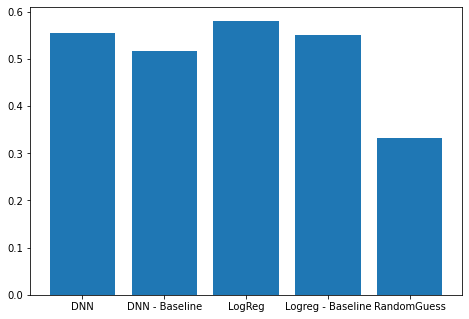

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
names = ['DNN', 'DNN - Baseline', 'LogReg', 'Logreg - Baseline', 'RandomGuess']
vals = [0.554, 0.517, 0.581, 0.55, 0.333]
ax.bar(names,vals)
plt.show()

In [14]:
from sklearn.preprocessing import MinMaxScaler
home_data = df.groupby('HomeTeam').sum()
away_data = df.groupby('AwayTeam').sum()
home_data['HAS'] = home_data['FTHG'] / 19 # Home Average Scores
home_data['HAC'] = home_data['FTAG'] / 19 # Home Average Conceded
away_data['AAS'] = away_data['FTAG'] / 19 # Away average Scored
away_data['AAC'] = away_data['FTHG'] / 19 # Away Average Conceded

home_data['HASh'] = (home_data['HST'] + home_data['HS']) / 19 # Home Average Scores
home_data['HAShC'] = (home_data['AST'] + home_data['AS']) / 19 # Home Average Conceded
away_data['AASh'] = (away_data['AST'] + away_data['AS']) / 19 # Away average Scored
away_data['AAShC'] = (away_data['HST'] + away_data['HS']) / 19 # Away Average Conceded

home_data['HC'] = home_data['HC'] / 19 # Home Average Scores
home_data['HCA'] = home_data['AC'] / 19 # Home Average Conceded
away_data['AC'] = away_data['AC'] / 19 # Away average Scored
away_data['ACA'] = away_data['HC'] / 19 # Away Average Conceded

print(home_data)
all_data_backup = df
df
team_data = pd.DataFrame()
team_data['Team'] = home_data.index

team_data = team_data.merge(home_data['HAS'], left_on='Team', right_index=True)
team_data = team_data.merge(home_data['HAC'], left_on='Team', right_index=True)
team_data = team_data.merge(home_data['HASh'], left_on='Team', right_index=True)
team_data = team_data.merge(home_data['HAShC'], left_on='Team', right_index=True)

# team_data['AHSH'] = team_data['HS'] / 19 # Average Home Shots Hit
# team_data['AAST'] = team_data['AS'] / 19 # Average Away Shots Taken
# team_data = team_data.drop(['HS', 'AS'], axis=1)

team_data = team_data.merge(away_data['AAS'], left_on='Team', right_index=True)
team_data = team_data.merge(away_data['AAC'], left_on='Team', right_index=True)
team_data = team_data.merge(away_data['AASh'], left_on='Team', right_index=True)
team_data = team_data.merge(away_data['AAShC'], left_on='Team', right_index=True)

# team_data['AASH'] = team_data['AS'] / 19 # Average Away Shots Hit
# team_data['AHST'] = team_data['HS'] / 19 # Average Home Shots Taken
# team_data = team_data.drop(['AS', 'HS'], axis=1)

team_data = team_data.merge(home_data['HC'], left_on='Team', right_index=True)
team_data = team_data.merge(home_data['HCA'], left_on='Team', right_index=True)
team_data = team_data.merge(away_data['AC'], left_on='Team', right_index=True)
team_data = team_data.merge(away_data['ACA'], left_on='Team', right_index=True)

team_data.set_index("Team", inplace=True)
last_season_table= pd.DataFrame(index=team_data.index)
scaler = MinMaxScaler()
team_data = pd.DataFrame(scaler.fit_transform(team_data), columns=team_data.columns, index=team_data.index)
team_data

                FTHG  FTAG  HTHG  HTAG   HS   AS  HST  AST   HF   AF  \
HomeTeam                                                               
Arsenal           25    14    10     4  288  155   91   49  149  161   
Aston Villa       24    25    10    12  170  173   63   62  142  198   
Brentford         18    19     4    10  186  178   65   62  156  154   
Brighton          10    20     6    11  237  188   49   69  174  154   
Burnley           13    20     7    10  173  219   51   68  165  138   
Chelsea           29    14    12     3  231  129   87   49  166  167   
Crystal Palace    25    17     9    10  193  161   64   56  175  213   
Everton           20    19     6     8  183  180   58   62  133  174   
Leeds             18    30     8    13  233  222   68   92  197  165   
Leicester         26    20    13    10  184  237   69   75  122  174   
Liverpool         39     7    18     3  321  107  116   37  143  127   
Man City          42    12    21     4  278   85  106   37  127 

,HAS,HAC,HASh,HAShC,AAS,AAC,AASh,AAShC,HC,HCA,AC,ACA
Team,,,,,,,,,,,,
Arsenal,0.46875,0.233333,0.727700,0.427083,0.37500,0.466667,0.307359,0.477876,0.647887,0.4750,0.0750,0.263158
Aston Villa,0.43750,0.600000,0.042254,0.588542,0.31250,0.433333,0.419913,0.544248,0.169014,0.7500,0.5500,0.666667
Brentford,0.25000,0.400000,0.126761,0.614583,0.40625,0.700000,0.281385,0.853982,0.126761,0.7625,0.0750,1.000000
Brighton,0.00000,0.433333,0.291080,0.703125,0.31250,0.300000,0.294372,0.469027,0.563380,0.5125,0.2750,0.771930
Burnley,0.09375,0.433333,0.000000,0.859375,0.12500,0.533333,0.060606,0.836283,0.239437,0.7250,0.1750,0.912281
Chelsea,0.59375,0.233333,0.441315,0.291667,0.84375,0.033333,0.575758,0.207965,0.718310,0.4125,0.4000,0.385965
Crystal Palace,0.46875,0.333333,0.154930,0.494792,0.31250,0.500000,0.108225,0.561947,0.197183,0.5000,0.1625,0.596491
Everton,0.31250,0.400000,0.079812,0.625000,0.15625,0.833333,0.264069,0.703540,0.225352,0.6125,0.0125,0.631579
Leeds,0.25000,0.766667,0.361502,1.000000,0.37500,1.000000,0.454545,0.929204,0.338028,0.5875,0.2250,0.403509


In [15]:
col_list2 = ['HomeTeam', 'AwayTeam']
data_prep = df[col_list2]

data_prep = data_prep.merge(team_data['HAS'], left_on='HomeTeam', right_index=True, how='left')
data_prep = data_prep.merge(team_data['HAC'], left_on='HomeTeam', right_index=True, how='left') 
data_prep = data_prep.merge(team_data['AAS'], left_on='AwayTeam', right_index=True, how='left') 
data_prep = data_prep.merge(team_data['AAC'], left_on='AwayTeam', right_index=True, how='left') 

data_prep = data_prep.merge(team_data['HASh'], left_on='HomeTeam', right_index=True, how='left')
data_prep = data_prep.merge(team_data['HAShC'], left_on='HomeTeam', right_index=True, how='left') 
data_prep = data_prep.merge(team_data['AASh'], left_on='AwayTeam', right_index=True, how='left') 
data_prep = data_prep.merge(team_data['AAShC'], left_on='AwayTeam', right_index=True, how='left') 

data_prep = data_prep.merge(team_data['HC'], left_on='HomeTeam', right_index=True, how='left')
data_prep = data_prep.merge(team_data['HCA'], left_on='HomeTeam', right_index=True, how='left') 
data_prep = data_prep.merge(team_data['AC'], left_on='AwayTeam', right_index=True, how='left') 
data_prep = data_prep.merge(team_data['ACA'], left_on='AwayTeam', right_index=True, how='left') 
# data_prep = data_prep.merge(team_data['AHSH'], left_on='HomeTeam', right_index=True, how='left') 
# data_prep = data_prep.merge(team_data['AHST'], left_on='HomeTeam', right_index=True, how='left') 

# data_prep = data_prep.merge(team_data['AASH'], left_on='AwayTeam', right_index=True, how='left') 
# data_prep = data_prep.merge(team_data['AAST'], left_on='AwayTeam', right_index=True, how='left') 

# data_prep['HAtS'] = data_prep['HAS'] * data_prep['AAC'] * data_prep['AHSH'] * data_prep['AAST']; # Home Attack Strength
# data_prep['AAtS'] = data_prep['HAC'] * data_prep['AAS'] * data_prep['AHST'] * data_prep['AASH']; # Away Attack Strength

data_prep['HAtS'] = (data_prep['HAS'] * data_prep['AAC'] + data_prep['HASh'] * data_prep['AAShC']); # Home Attack Strength + data_prep['HASh'] * data_prep['AAShC']
data_prep['AAtS'] = (data_prep['HAC'] * data_prep['AAS'] + data_prep['HAShC'] * data_prep['AASh']); # Away Attack Strength + data_prep['HAShC'] * data_prep['AASh']

print(data_prep.shape)

data_prep = data_prep.merge(df['FTR'], left_index=True, right_index=True)

fixture_list = data_prep
data_prep.head()

(309, 16)


,HomeTeam,AwayTeam,HAS,HAC,AAS,AAC,HASh,HAShC,AASh,AAShC,HC,HCA,AC,ACA,HAtS,AAtS,FTR
0,Brentford,Arsenal,0.25000,0.400000,0.37500,0.466667,0.126761,0.614583,0.307359,0.477876,0.126761,0.7625,0.0750,0.263158,0.177243,0.338898,H
1,Man United,Leeds,0.46875,0.400000,0.37500,1.000000,0.483568,0.661458,0.454545,0.929204,0.338028,0.5625,0.2250,0.403509,0.918083,0.450663,H
2,Burnley,Brighton,0.09375,0.433333,0.31250,0.300000,0.000000,0.859375,0.294372,0.469027,0.239437,0.7250,0.2750,0.771930,0.028125,0.388393,A
3,Chelsea,Crystal Palace,0.59375,0.233333,0.31250,0.500000,0.441315,0.291667,0.108225,0.561947,0.718310,0.4125,0.1625,0.596491,0.544870,0.104482,H
4,Everton,Southampton,0.31250,0.400000,0.28125,0.800000,0.079812,0.625000,0.437229,0.526549,0.225352,0.6125,0.5375,0.385965,0.292025,0.385768,H


In [16]:
rm_col_list = ['HomeTeam','AwayTeam']
col_list = data_prep.columns.values.tolist()
col_list = [x for x in col_list if x not in rm_col_list]

to_use = data_prep[col_list]
X = [x for x in col_list if x != 'Result']
Y = [x for x in col_list if x == 'Result']

to_use.head()

,HAS,HAC,AAS,AAC,HASh,HAShC,AASh,AAShC,HC,HCA,AC,ACA,HAtS,AAtS,FTR
0,0.25000,0.400000,0.37500,0.466667,0.126761,0.614583,0.307359,0.477876,0.126761,0.7625,0.0750,0.263158,0.177243,0.338898,H
1,0.46875,0.400000,0.37500,1.000000,0.483568,0.661458,0.454545,0.929204,0.338028,0.5625,0.2250,0.403509,0.918083,0.450663,H
2,0.09375,0.433333,0.31250,0.300000,0.000000,0.859375,0.294372,0.469027,0.239437,0.7250,0.2750,0.771930,0.028125,0.388393,A
3,0.59375,0.233333,0.31250,0.500000,0.441315,0.291667,0.108225,0.561947,0.718310,0.4125,0.1625,0.596491,0.544870,0.104482,H
4,0.31250,0.400000,0.28125,0.800000,0.079812,0.625000,0.437229,0.526549,0.225352,0.6125,0.5375,0.385965,0.292025,0.385768,H


In [17]:
X_data = to_use.drop('FTR', axis=1)
Y_data = to_use['FTR']
X_data = X_data.fillna(0)
Y_data = Y_data.fillna('D')
model = LogisticRegression(max_iter=10000)
model.fit(X_data, Y_data)
model.score(X_data, Y_data)

0.598705501618123

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

model1 = LogisticRegression(max_iter=10000)
model1.fit(X_train, Y_train)

LogisticRegression(max_iter=10000)

In [19]:
predicted = model1.predict(X_test)
predicted

array(['H', 'A', 'H', 'H', 'H', 'H', 'H', 'A', 'A', 'H', 'H', 'H', 'H',
       'H', 'H', 'H', 'H', 'A', 'H', 'A', 'H', 'H', 'H', 'A', 'A', 'A',
       'H', 'A', 'H', 'H', 'A', 'H', 'H', 'A', 'H', 'A', 'A', 'A', 'H',
       'H', 'A', 'A', 'A', 'A', 'H', 'A', 'H', 'A', 'H', 'A', 'A', 'H',
       'H', 'A', 'A', 'A', 'H', 'A', 'H', 'H', 'H', 'A'], dtype=object)

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
acc_score1 = model1.score(X_test, Y_test)
print("Logistic Regression Accuracy score: " + str(acc_score1))
scores = cross_val_score(model1, X_train, Y_train, cv=10)
print("Cross val scores")
print(scores)

Logistic Regression Accuracy score: 0.5806451612903226
Cross val scores
[0.4        0.56       0.64       0.6        0.56       0.56
 0.6        0.5        0.625      0.54166667]


In [22]:
score_train = model1.score(X_train, Y_train)
score_test = model1.score(X_test, Y_test)

print("Training set accuracy: ", '%.3f'%(score_train))
print("Test set accuracy: ", '%.3f'%(score_test))

Training set accuracy:  0.575
Test set accuracy:  0.581


In [23]:
predicted = model1.predict(X_data)
predicted
predictedDF = pd.DataFrame(predicted, columns=['Predicted'])
predictedDF.head()

,Predicted
0,A
1,H
2,A
3,H
4,H


In [ ]:


# X_train, X_test, Y_train, Y_test = train_test_split(complete_features_fillna1,complete_targets_fillna, test_size=0.2, random_state=42)
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import cross_val_score
# model1 = LogisticRegression(max_iter=10000)
# model1.fit(X_train, Y_train)
# predicted = model1.predict(X_test)
# acc_score = accuracy_score(Y_test, predicted)
# print("Accuracy score: " + str(model.score(complete_features_fillna1,complete_targets_fillna)))
# scores = cross_val_score(model1, X_train, Y_train, cv=10)
# print("Cross val scores")
# print(scores)
# score_train = model1.score(X_train, Y_train)
# score_test = model1.score(X_test, Y_test)

# print("Training set accuracy: ", '%.3f'%(score_train))
# print("Test set accuracy: ", '%.3f'%(score_test))

In [ ]:
# predicted = model1.predict(complete_features_fillna1)
# predicted
# predictedDF = pd.DataFrame(predicted, columns=['Predicted'])
# predictedDF.head()

In [25]:
copyData = copy.deepcopy(raw_season_data[0])
copyData['predicted'] = predictedDF
# fixture_list = copy.deepcopy(seasonTable[0])
# fixture_list = fixture_list.merge(predictedDF, left_index=True, right_index=True)
# fixture_list
pd.set_option('display.max_rows', None)
copyData.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,predicted
0,E0,13/08/2021,Brentford,Arsenal,2,0,H,1,0,H,8,22,3,4,12,8,2,5,0,0,0,0,A
1,E0,14/08/2021,Man United,Leeds,5,1,H,1,0,H,16,10,8,3,11,9,5,4,1,2,0,0,H
2,E0,14/08/2021,Burnley,Brighton,1,2,A,1,0,H,14,14,3,8,10,7,7,6,2,1,0,0,A
3,E0,14/08/2021,Chelsea,Crystal Palace,3,0,H,2,0,H,13,4,6,1,15,11,5,2,0,0,0,0,H
4,E0,14/08/2021,Everton,Southampton,3,1,H,0,1,A,14,6,6,3,13,15,6,8,2,0,0,0,H


In [27]:
def create_home_dict_predicted(table,matchNum):
    matchDict={}
    if any('predicted' == table.keys()):
        matchDict={'predicted':table['predicted'].values[0]}
    elif any('Res'== table.keys()):
        matchDict = {'result':table['Res'].values[0]}
    if any('FTHG' == table.keys()):
        matchDict.update({'Goals':table['FTHG'].values[0]})
    elif any('HG'== table.keys()):
        matchDict.update({'Goals':table['HG'].values[0]})
    if any('FTAG' == table.keys()):
        matchDict.update({'GoalsConceded':table['FTAG'].values[0]})
    elif any('AG'== table.keys()):
        matchDict.update({'GoalsConceded':table['AG'].values[0]})
    matchDict.update({'match':matchNum,'ground':'H', \
                        'Date':table['Date'].values[0],\
                        'TeamAgainst':table['AwayTeam'].values[0],\
                        'HTGoals':table['HTHG'].values[0], \
                        'HTResult':table['HTR'].values[0], \
                        #'Attendance':table['Attendance'].values[0], \
                        'Shots':table['HS'].values[0],\
                        'ShotsAgainst':table['AS'].values[0],\
                        'ShotsOnTarget':table['HST'].values[0],\
                        'ShotsAgainstOnTarget':table['AST'].values[0],\
                        #'ShotsWoodwork':table['HHW'].values[0],\
                        #'ShotsAgainstWoodwork':table['AHW'].values[0],\
                        'Corners':table['HC'].values[0],\
                        'CornersAgainst':table['AC'].values[0],\
                        'FoulsCommited':table['HF'].values[0],\
                        'FoulsAgainst':table['AF'].values[0],\
                        #'Offsies':table['HO'].values[0],\
                        #'OffsidesAgainst':table['AO'].values[0],\
                        'YCards':table['HY'].values[0],\
                        'YCardsAgainst':table['AY'].values[0],\
                        'RCards':table['HR'].values[0],\
                        'RCardsAgainst':table['AR'].values[0]})
                        #'BookingPoints':table['HBP'].values[0],\
                        #'BookingPointsAgainst':table['ABP'].values[0]})

    matchDict.update({'BigChancesCreated': matchDict['ShotsOnTarget']+matchDict['Goals']*4})
    if matchDict['predicted']=='H':
        matchDict.update({'Win':1,'Draw':0, 'Lose':0})
    elif matchDict['predicted']=='A':
        matchDict.update({'Win':0,'Draw':0, 'Lose':1})
    else:
        matchDict.update({'Win':0,'Draw':1, 'Lose':0})
    return pd.DataFrame(matchDict,index=[matchNum,])


def create_away_dict_predicted(table,matchNum):
    matchDict={}
    if any('predicted' == table.keys()):
        matchDict={'predicted':table['predicted'].values[0]}
    elif any('Res'== table.keys()):
        matchDict = {'result':table['Res'].values[0]}
    if any('FTHG' == table.keys()):
        matchDict.update({'GoalsConceded':table['FTHG'].values[0]})
    elif any('HG'== table.keys()):
        matchDict.update({'GoalsConceded':table['HG'].values[0]})
    if any('FTAG' == table.keys()):
        matchDict.update({'Goals':table['FTAG'].values[0]})
    elif any('AG'== table.keys()):
        matchDict.update({'Goals':table['AG'].values[0]})
    matchDict.update({'match':matchNum,'ground':'A', \
                        'Date':table['Date'].values[0],\
                        'TeamAgainst':table['HomeTeam'].values[0],\
                        'HTGoals':table['HTAG'].values[0], \
                        'HTResult':table['HTR'].values[0], \
                        #'Attendance':table['Attendance'].values[0], \
                        'Shots':table['AS'].values[0],\
                        'ShotsAgainst':table['HS'].values[0],\
                        'ShotsOnTarget':table['AST'].values[0],\
                        'ShotsAgainstOnTarget':table['HST'].values[0],\
                        #'ShotsWoodwork':table['AHW'].values[0],\
                        #'ShotsAgainstWoodwork':table['HHW'].values[0],\
                        'Corners':table['AC'].values[0],\
                        'CornersAgainst':table['HC'].values[0],\
                        'FoulsCommited':table['AF'].values[0],\
                        'FoulsAgainst':table['HF'].values[0],\
                        #'Offsies':table['AO'].values[0],\
                        #'OffsidesAgainst':table['HO'].values[0],\
                        'YCards':table['AY'].values[0],\
                        'YCardsAgainst':table['HY'].values[0],\
                        'RCards':table['AR'].values[0],\
                        'RCardsAgainst':table['HR'].values[0]})
                        #'BookingPoints':table['ABP'].values[0],\
                        #'BookingPointsAgainst':table['HBP'].values[0]})
    matchDict.update({'BigChancesCreated': matchDict['ShotsOnTarget']+matchDict['Goals']*4})
    if matchDict['predicted']=='A':
        matchDict.update({'Win':1,'Draw':0, 'Lose':0})
    elif matchDict['predicted']=='H':
        matchDict.update({'Win':0,'Draw':0, 'Lose':1})
    else:
        matchDict.update({'Win':0,'Draw':1, 'Lose':0})
    return pd.DataFrame(matchDict,index=[matchNum,])

# The function below runs through each season, and each distinct team for that season and 
# uses the above functions to build the snapshot database

def build_snapshot_table_predicted(raw_data,snapshots):
    # for i in raw_data.keys():
        snapshots={}
        for j in list(set(raw_data['AwayTeam'])):
            snapshots[j] = pd.DataFrame()
            tsTable=raw_data[(raw_data['AwayTeam']==j) | (raw_data['HomeTeam']==j)]
            for k in range(len(tsTable)):
                if j == tsTable.iloc[k]['AwayTeam']:
                    snapshots[j] = snapshots[j].append(create_away_dict_predicted(tsTable[k:k+1],k+1))
                elif j == tsTable.iloc[k]['HomeTeam']:
                    snapshots[j] = snapshots[j].append(create_home_dict_predicted(tsTable[k:k+1],k+1))
        return snapshots

snapshots1={}
helper111 = build_snapshot_table_predicted(copyData, snapshots1)

# build_season_table(helper111)

In [31]:
# Take entire dataframe and build a single row of aggregations
def build_season_stats(teamDF,team):
    return {'Team': team,
    'Wins': sum(teamDF['Win']),
    'Losses': sum(teamDF['Lose']),
    'Draws': sum(teamDF['Draw']),
    'Goals': sum(teamDF['Goals']),
    'GoalsAgainst': sum(teamDF['GoalsConceded']),
    'YCards': sum(teamDF['YCards']),
    'RCards': sum(teamDF['RCards']),
    'avg_Goals':np.mean(teamDF['Goals']),
    'avg_GoalsAgainst':np.mean(teamDF['GoalsConceded']),
    'avg_Corners':np.mean(teamDF['Corners']),
    'avg_CornersAgaints':np.mean(teamDF['CornersAgainst']),
    'avg_Fouls':np.mean(teamDF['FoulsCommited']),
    'avg_FoulsAgainst':np.mean(teamDF['FoulsAgainst']),
    'avg_Shots':np.mean(teamDF['Shots']),
    'avg_ShotsAgainst':np.mean(teamDF['ShotsAgainst']),
    'avg_BigChancesCreated':np.mean(teamDF['BigChancesCreated']),
    }
## Take a season + team snapshot, query all,home and away games into smaller dataframes and feed them into build_season_stats,
## Add home and away prefix to show aggregations specific to the stadiums.
def build_team_summary(teamDF,team):
    # homeDF = teamDF.query('ground == "H" ')
    # awayDF = teamDF.query('ground == "A" ')
    seasonDict = build_season_stats(teamDF, team)
    # homeDict = build_season_stats(homeDF,team)
    # awayDict = build_season_stats(awayDF, team)
    # homeDict = dict(zip(["home_" + i for i in homeDict.keys()],homeDict.values()))
    # awayDict = dict(zip(["away_" + i for i in awayDict.keys()],awayDict.values()))
    # seasonDict= {**seasonDict,**homeDict,**awayDict}
    seasonDict = {**seasonDict,**{'Points' : 3*seasonDict['Wins'] + (1 *seasonDict['Draws']), 'GD': seasonDict['Goals'] - seasonDict['GoalsAgainst']  }}

    return pd.DataFrame(seasonDict,index=[team,])

## Build entire database, take snapshots data and run through season+team data.
def build_season_table(snapshots):
    seasonTab = {}
    # print(snapshots.keys())
    # print(snapshots.keys())
    for i in snapshots.keys():
        
      seasonTab[i] = pd.DataFrame()
      for k in snapshots.keys():
        seasonTab[i] = seasonTab[i].append(build_team_summary(snapshots[k],k))
      seasonTab[i] = seasonTab[i].sort_values(by=['Points','GD'],ascending=False)
      seasonTab[i]['Position'] = np.linspace(1,20,20)
      return seasonTab

## build into seasonTable
seasonTable = build_season_table(helper111)
print(seasonTable)
print("THIS DATA IS THE PREDICTED SEASON TABLE THROUGH MATCHWEEK 32. WE PREDICTED THE FINAL 5 GAMES OF THE SEASON USING THIS BY ADDING IN THE 5 CITY GAMES AND 5 LIVERPOOL GAMES TO GET THE MODEL'S PREDICTION.")

{'Newcastle':                           Team  Wins  Losses  Draws  Goals  GoalsAgainst  \
Liverpool            Liverpool    29       0      2     79            22   
Man City              Man City    28       0      3     72            20   
Chelsea                Chelsea    26       3      1     64            23   
Man United          Man United    25       6      0     49            42   
Tottenham            Tottenham    24       7      0     56            37   
Arsenal                Arsenal    23       7      0     45            36   
West Ham              West Ham    23       9      0     51            42   
Wolves                  Wolves    17      15      0     33            28   
Crystal Palace  Crystal Palace    16      14      1     43            40   
Aston Villa        Aston Villa    14      15      2     42            46   
Southampton        Southampton    14      16      1     37            52   
Brighton              Brighton     9      14      8     28            37  